**Суть задачи**: есть набор данных о стоимости аредны в сутки (daily_price) апартаментов одного типа в Милане. 9300+ наблюдений. Разобьём множество на трэйн и тест и попытаемся предсказать стоимость аренды. В первичном наборе 61 признак. <br>
**Как определеяем качество**: Ориентироваться будем на MAE. Дабы не подгоняться под тестовое множество, будем смотреть эту ошибку на кроссвалидации. Модель, которая покажет лучший результат на кроссвалидации будет применять к тестовому множеству. Итоговый результат: MAE, который показывает модель на тесте. <br>
**Вид модели**: протестируем ряд регрессионных моделей с подобранными параметрами. А именно: <br>
- XGB Regression
- XGBRF Regression
- Light GBM
- Random Forest
- Linear Regression
- Ridge
- Стэкинг вышеперечисленных моделей.

In [157]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import RandomizedSearchCV

from lightgbm import LGBMRegressor

import xgboost as xgb

os.chdir(r'C:\Users\user\Desktop\test')

In [3]:
df = pd.read_csv('Airbnb_Milan.csv')
df.head()

,Unnamed: 0,id,host_id,host_location,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,...,Iron,Host_greets_you,Paid_parking_on_premises,Luggage_dropoff_allowed,Long_term_stays_allowed,Doorman,Pets_allowed,Smoking_allowed,Suitable_for_events,24_hour_check_in
0,1,73892,387110,1,1,57,0,3,1,1,...,1,0,0,0,0,0,0,0,1,0
1,2,74169,268127,1,1,57,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
2,3,77958,387110,1,1,57,0,3,1,1,...,1,0,0,0,0,0,0,0,1,0
3,4,93025,499743,1,1,57,0,1,1,0,...,1,0,1,1,0,0,1,0,0,0
4,5,132705,391011,1,1,57,1,2,1,0,...,1,1,0,0,0,0,0,0,0,0


In [4]:
df = df.iloc[:, 3:]

Выясним, какие столбцы сильно коррелированы друг с другом (> 0.7)

In [5]:
for i in df.corr().columns:
    for j in df.corr().index:
        if df.corr().loc[i, j] > 0.7 and i != j:
            print(i, '+', j)

neighbourhood_cleansed + zipcode
zipcode + neighbourhood_cleansed
accommodates + beds
beds + accommodates
availability_30 + availability_60
availability_30 + availability_90
availability_60 + availability_30
availability_60 + availability_90
availability_90 + availability_30
availability_90 + availability_60
review_scores_rating + review_scores_accuracy
review_scores_rating + review_scores_value
review_scores_accuracy + review_scores_rating
review_scores_value + review_scores_rating
require_guest_profile_picture + require_guest_phone_verification
require_guest_phone_verification + require_guest_profile_picture


Оставим по одному столбцу из пары или тройки. Для столбцов с доступностью выведем новую метрику: усреднённая доля доступности по периодам за 30, 60, 90 дней.

In [5]:
to_drop = ['zipcode', 'accommodates', 'review_scores_accuracy', 'review_scores_value', \
           'require_guest_phone_verification', 'availability_60', 'availability_30', 'availability_90']
df['availability'] = (df.availability_30/30 + df.availability_60/60 + df.availability_90/90)/3
df.drop(columns = to_drop, inplace = True)

Разберёмся с единственным столбцом типа object.

In [6]:
df.room_type.unique().tolist()

['Entire home/apt']

Датасет построен так, что мы рассматриваем только определённые типы комнат (Entire home/apt). Удалим этот столбец. 

In [7]:
df.drop(columns = 'room_type', inplace = True)

Проверим столбцы с бинарными значениями на дисбаланс и удалим слишком расбалансированные, логически незначительной важности. 

In [8]:
disbalanced = []
for column in df.columns:
    if df[column].nunique() == 2:
        if df[column].value_counts(normalize = True).values[0] > 0.9:
            disbalanced.append(column)
        elif df[column].value_counts(normalize = True).values[0] < 0.1:
            disbalanced.append(column)
for column in disbalanced:
    print(df[column].value_counts(normalize = True), end = '\n\n')

1    0.959558
0    0.040442
Name: host_location, dtype: float64

1    0.999571
0    0.000429
Name: host_has_profile_pic, dtype: float64

0    0.985411
1    0.014589
Name: require_guest_profile_picture, dtype: float64

1    0.928556
0    0.071444
Name: WiFi, dtype: float64

0    0.957842
1    0.042158
Name: Wheelchair_accessible, dtype: float64

1    0.967282
0    0.032718
Name: Kitchen, dtype: float64

1    0.980691
0    0.019309
Name: Heating, dtype: float64

0    0.963634
1    0.036366
Name: Suitable_for_events, dtype: float64

0    0.914718
1    0.085282
Name: 24_hour_check_in, dtype: float64



In [9]:
df.drop(columns = ['host_has_profile_pic', 'Suitable_for_events'], inplace = True)

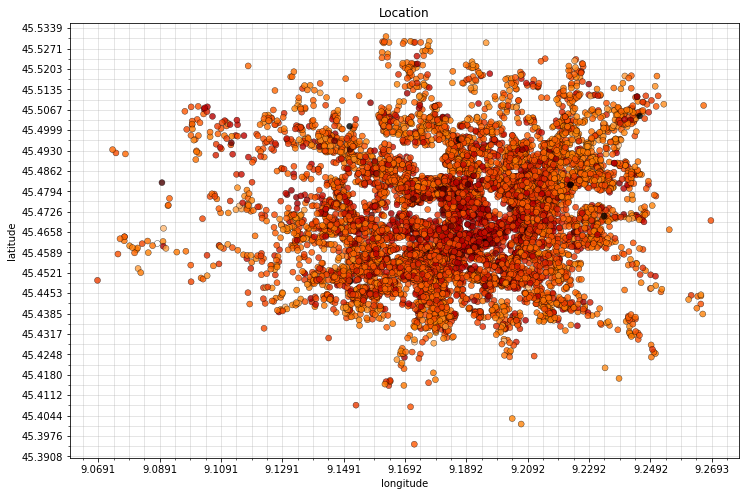

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches((12,8))
ax.scatter(df.longitude, df.latitude, c = np.log(df.daily_price), \
           cmap = 'gist_heat_r', edgecolor = 'black', linewidth = 0.4, alpha = 0.8)
ax.xaxis.set_major_locator(ticker.MultipleLocator((df.longitude.max() - df.longitude.min())/10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator((df.longitude.max() - df.longitude.min())/40))
ax.yaxis.set_major_locator(ticker.MultipleLocator((df.latitude.max() - df.latitude.min())/20))
ax.yaxis.set_minor_locator(ticker.MultipleLocator((df.latitude.max() - df.latitude.min())/40))
ax.grid(alpha = 0.4, which = 'both')
ax.set_axisbelow(True)
ax.set_ylim((df.latitude.min()*0.9999, df.latitude.max()*1.0001))
ax.set_xlim((df.longitude.min()*0.999, df.longitude.max()*1.001))
ax.set_ylabel('latitude'), ax.set_xlabel('longitude'), ax.set_title('Location')
plt.show()

Создадим новый признак, показывающий дистанцию до центра (координаты собора Дуомо).

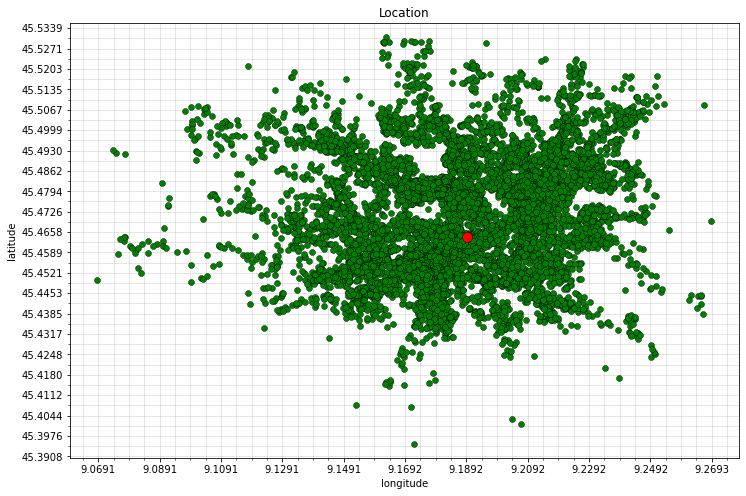

In [10]:
from geopy.distance import great_circle

Milano_centre = [45.4642715, 9.1895103]

def distance(lat_room, lon_room, Milano_centre):
    room = (lat_room, lon_room)
    return great_circle(Milano_centre, room).km

fig, ax = plt.subplots()
fig.set_size_inches((12,8))
ax.scatter(df.longitude, df.latitude, color = 'green', edgecolor = 'black', linewidth = 0.4)
ax.scatter(Milano_centre[1], Milano_centre[0], color = 'red', s = 100, edgecolor = 'black', linewidth = 0.4)
ax.xaxis.set_major_locator(ticker.MultipleLocator((df.longitude.max() - df.longitude.min())/10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator((df.longitude.max() - df.longitude.min())/40))
ax.yaxis.set_major_locator(ticker.MultipleLocator((df.latitude.max() - df.latitude.min())/20))
ax.yaxis.set_minor_locator(ticker.MultipleLocator((df.latitude.max() - df.latitude.min())/40))
ax.grid(alpha = 0.4, which = 'both')
ax.set_axisbelow(True)
ax.set_ylim((df.latitude.min()*0.9999, df.latitude.max()*1.0001))
ax.set_xlim((df.longitude.min()*0.999, df.longitude.max()*1.001))
ax.set_ylabel('latitude'), ax.set_xlabel('longitude'), ax.set_title('Location')
plt.show()

Добавим дистанцию до центра как признак.

In [11]:
df['center_distance'] = df.apply(lambda x: distance(x.latitude, x.longitude, Milano_centre), axis = 1)

Прежде, чем переходить к построению моделей, взглянем на распределение цен по квартилям.

In [12]:
qlist = np.linspace(0.05, 1, 20)
df.daily_price.quantile(qlist)

0.05      40.0
0.10      48.0
0.15      50.0
0.20      55.0
0.25      59.0
0.30      60.0
0.35      65.0
0.40      69.0
0.45      70.0
0.50      75.0
0.55      80.0
0.60      85.0
0.65      90.0
0.70      99.0
0.75     107.0
0.80     120.0
0.85     145.0
0.90     170.0
0.95     240.0
1.00    3000.0
Name: daily_price, dtype: float64

In [13]:
qlist = np.linspace(0.9, 1, 11)
df.daily_price.quantile(qlist)

0.90     170.00
0.91     180.00
0.92     194.32
0.93     200.00
0.94     209.74
0.95     240.00
0.96     250.00
0.97     300.00
0.98     350.00
0.99     500.00
1.00    3000.00
Name: daily_price, dtype: float64

In [14]:
df.daily_price[df.daily_price > 1000]

549     1600
897     1200
906     3000
907     3000
1373    1500
1520    3000
1543    3000
2802    3000
3870    3000
3892    3000
4834    3000
6686    3000
6951    3000
8419    3000
9300    3000
Name: daily_price, dtype: int64

Удалим объекты, у которых стоимость аренды в сутки = 3000. Их достаточно мало, и очевидно, что это уникальные объекты, на которых модель так и так будет вести себя плохо и незаурядно. Позволим модели сконцентрироваться на более точном предсказании основной массы значений.

In [15]:
df = df[df.daily_price != 3000]

<h3>Построение моделей.</h3>
<br>
Для начала определим функции, которые автоматизируют работу в дальнейшем:

In [16]:
def error_compare(test, pred): # график, по х - реальные значения, по у - полученные (в логарифмических координатах)
                               # логарифмические, потому что есть большие значения-выбросы.
    fig, ax = plt.subplots()
    fig.set_size_inches((12,5))
    ax.scatter(np.log(test), np.log(pred), color = 'red', edgecolor = 'black', linewidth = 0.4)
    ax.set_axisbelow(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
    ax.grid(alpha = 0.4, which = 'both')
    ax.set_xlim((min(min(np.log(test)+0.5), min(np.log(pred)+0.5)), max(max(np.log(test)+0.5), max(np.log(pred)+0.5))))
    ax.set_ylim((min(min(np.log(test)+0.5), min(np.log(pred)+0.5)), max(max(np.log(test)+0.5), max(np.log(pred)+0.5))))
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--', color = 'black')
    ax.set_ylabel('predict test (log)'), ax.set_xlabel('test (log)'), ax.set_title('Predict-test graph')
    plt.show()
    #... and print errors
    print('MAE: {}'.format(mean_absolute_error(test, pred)))

def validation(model, X_train, y_train): #кроссвалидация, 5 фолдов
    print('MAE: {}'.format(abs(cross_val_score(model, X_train, y_train, \
                                               cv = 5, scoring = 'neg_mean_absolute_error').mean())))

# функция, визуализирующая поиск оптимального параметра
def param_search(model, X_train, y_train, target, params, param_list):
    mae_train_crossval = []
    for i in param_list:
        params[target] = i
        handle = model.set_params(**params)
        mae_train_crossval.append(abs(cross_val_score(handle, X_train, y_train, \
                                                  cv = 5, scoring = 'neg_mean_absolute_error').mean()))
    fig, ax = plt.subplots()
    fig.set_size_inches((16,4))
    ax.plot(param_list, mae_train_crossval, color = 'black', label = 'MAE on cv')
    ax.set_axisbelow(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(param_list[1] - param_list[0]))
    ax.set_xlim((min(param_list), max(param_list)))
    ax.legend()
    ax.grid()
    plt.show()

In [17]:
y = df.daily_price
X = df.drop(columns = 'daily_price')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7448, 48)
(1862, 48)
(7448,)
(1862,)


In [26]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

<h3>Linear Regression</h3>

In [27]:
lr = LinearRegression()
validation(lr, X_train, y_train)

MAE: 37.88968799497877


<h3>Ridge</h3>

In [28]:
r = Ridge()
validation(r, X_train, y_train)

MAE: 37.88839960414028


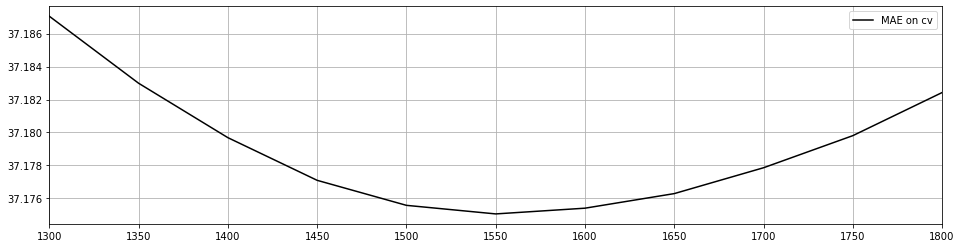

In [29]:
alpha = np.linspace(1300, 1800, 11)
target = 'alpha'
params = {}

param_search(r, X_train, y_train, target, params, alpha)

In [30]:
r_best = Ridge(alpha = 1550)
validation(r, X_train, y_train)

MAE: 37.18242501978157


<h3>Random Forest Regressor</h3>

К сожалению, в моём случае RF слишком трудоёмок даже для рандомного перебора. Поэтому попробуем несколько параметров вручную. Плюс откажемся от кроссвалидации и будем смотреть результат сразу на тестовом множестве.

In [76]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_res = rf.predict(X_test)
print('MAE: {}'.format(mean_absolute_error(y_test, rf_res)))

MAE: 34.96910848549946


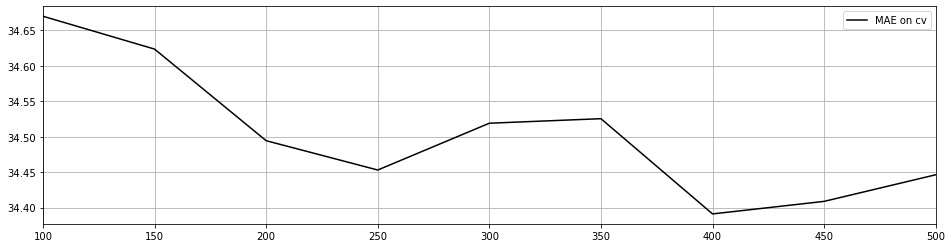

In [80]:
n_estimators = [i for i in range(100, 550, 50)]
target = 'n_estimators'
params = {}

rf = RandomForestRegressor()
param_search(rf, X_train, y_train, target, params, n_estimators)

In [82]:
rf = RandomForestRegressor(n_estimators = 400)
rf.fit(X_train, y_train)
rf_res = rf.predict(X_test)
print('MAE: {}'.format(mean_absolute_error(y_test, rf_res)))

MAE: 34.48202604726101


In [85]:
for i in range(6,12):
    rf = RandomForestRegressor(n_estimators = 400, max_depth = i)
    rf.fit(X_train, y_train)
    rf_res = rf.predict(X_test)
    cvs = cross_val_score(rf, X_train, y_train, cv = 4, scoring = 'neg_mean_absolute_error').mean()
    print('Max_depth = {}. Cross validation score: {}. MAE on test: {}'.format(i, cvs, mean_absolute_error(y_test, rf_res)))

Max_depth = 6. Cross validation score: -35.627766436067674. MAE on test: 35.24375972838891
Max_depth = 7. Cross validation score: -35.14065395257015. MAE on test: 34.755589582548566
Max_depth = 8. Cross validation score: -34.82507295935765. MAE on test: 34.70830359923572
Max_depth = 9. Cross validation score: -34.58895631542905. MAE on test: 34.43339121189491
Max_depth = 10. Cross validation score: -34.46577383404072. MAE on test: 34.09312332066881
Max_depth = 11. Cross validation score: -34.294264210844744. MAE on test: 34.224752515377006


После глубины 10 модель начинает терять качество на тесте. Остановимся на 10. 

In [87]:
for i in ['log2', 'sqrt']:
    rf = RandomForestRegressor(n_estimators = 400, max_depth = 10, max_features = i)
    rf.fit(X_train, y_train)
    rf_res = rf.predict(X_test)
    cvs = cross_val_score(rf, X_train, y_train, cv = 4, scoring = 'neg_mean_absolute_error').mean()
    print('Max_features = {}. Cross validation score: {}. MAE on test: {}'.format(i, cvs, mean_absolute_error(y_test, rf_res)))

Max_features = log2. Cross validation score: -34.063323157089435. MAE on test: 33.10486013682261
Max_features = sqrt. Cross validation score: -33.95833682215512. MAE on test: 32.78097927332474


Итого, при лучших подобранных параметрах:

In [88]:
rf_best = RandomForestRegressor(n_estimators = 400, max_depth = 10, max_features = 'sqrt')
validation(rf_best, X_train, y_train)

MAE: 33.93821913764857


<h3>Light GBM</h3>

In [32]:
lgbm = LGBMRegressor()
validation(lgbm, X_train, y_train)

MAE: 33.758015351825854


Подберём первичную комбинацию параметров с помощью RandomizedSearch, которую впоследствии уточним вручную.

In [94]:
params = {'n_estimators': [100, 150, 200, 300, 400], 'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5], \
         'colsample_bytree': [0.3, 0.4, 0.5, 0.7, 1], 'subsample': [0.3, 0.5, 0.7, 0.9, 1]}

lgbm = LGBMRegressor()
lgbm_rs = RandomizedSearchCV(lgbm, params, cv = 5, \
                           n_iter = 100, scoring = 'neg_mean_absolute_error')
lgbm_rs.fit(X_train, y_train)
print(lgbm_rs.best_params_)

{'subsample': 0.7, 'n_estimators': 150, 'learning_rate': 0.05, 'colsample_bytree': 0.4}


In [148]:
lgbm_rs_best = lgbm_rs.best_estimator_
validation(lgbm_rs_best, X_train, y_train)

MAE: 32.84635311132249


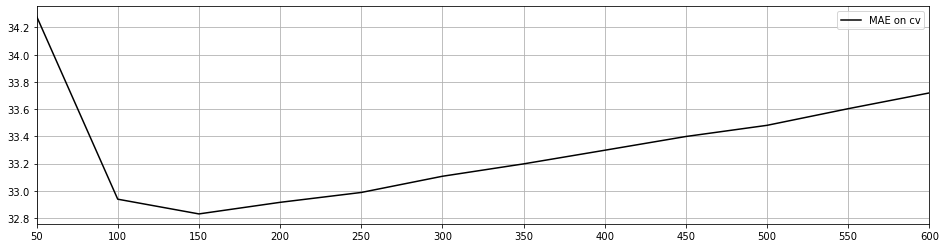

In [116]:
estimators = [i for i in range(50, 650, 50)]
target = 'n_estimators'
params = {'subsample': 0.7, 'n_estimators': 150, 'learning_rate': 0.05, 'colsample_bytree': 0.4}

lgbm_best = LGBMRegressor()
param_search(lgbm_best, X_train, y_train, target, params, estimators)

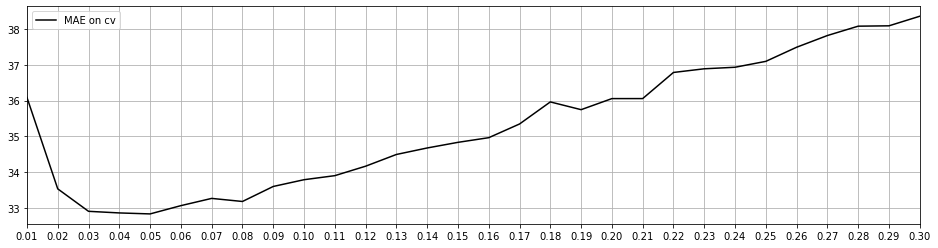

In [117]:
learning_rate = np.linspace(0.01, 0.3, 30)
target = 'learning_rate'
params = {'subsample': 0.7, 'n_estimators': 150, 'learning_rate': 0.05, 'colsample_bytree': 0.4}

lgbm_best = LGBMRegressor()
param_search(lgbm_best, X_train, y_train, target, params, learning_rate)

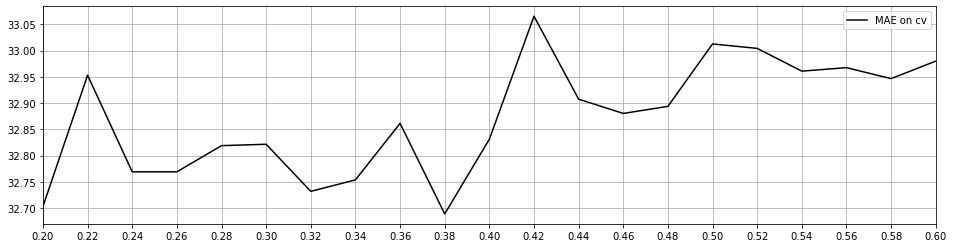

In [118]:
colsample_bytree = np.linspace(0.2, 0.6, 21)
target = 'colsample_bytree'
params = {'subsample': 0.7, 'n_estimators': 150, 'learning_rate': 0.05, 'colsample_bytree': 0.4}

lgbm_best = LGBMRegressor()
param_search(lgbm_best, X_train, y_train, target, params, colsample_bytree)

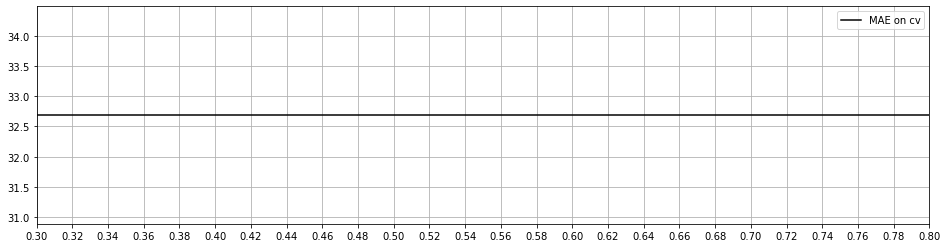

In [120]:
subsample = np.linspace(0.3, 0.8, 26)
target = 'subsample'
params = {'subsample': 0.7, 'n_estimators': 150, 'learning_rate': 0.05, 'colsample_bytree': 0.38}

lgbm_best = LGBMRegressor()
param_search(lgbm_best, X_train, y_train, target, params, subsample)

Итак, лучшие подобранные параметры: 

In [33]:
params = {'subsample': 0.7, 'n_estimators': 150, 'learning_rate': 0.05, 'colsample_bytree': 0.38}
lgbm_best = LGBMRegressor().set_params(**params)
validation(lgbm_best, X_train, y_train)

MAE: 32.79364175584406


<h3>XGBoost Regressor</h3>

In [152]:
xgbr = xgb.XGBRegressor()
validation(xgbr, X_train, y_train)

MAE: 35.73938130192008


In [155]:
params = {'n_estimators': [100, 150, 200, 300, 400], 'learning_rate': [0.01, 0.05, 0.1], \
         'colsample_bytree': [0.3, 0.4, 0.5, 0.7, 1], 'gamma': [0.01, 0.05, 0.1, 0.2]}

xgbr = xgb.XGBRegressor()
xgbr_rs = RandomizedSearchCV(xgbr, params, cv = 5, \
                           n_iter = 60, scoring = 'neg_mean_absolute_error')
xgbr_rs.fit(X_train, y_train)
print(xgbr_rs.best_params_)

{'n_estimators': 200, 'learning_rate': 0.01, 'gamma': 0.05, 'colsample_bytree': 0.4}


In [156]:
xgbr_rs_best = xgbr_rs.best_estimator_
validation(xgbr_rs_best, X_train, y_train)

MAE: 31.593401000354618


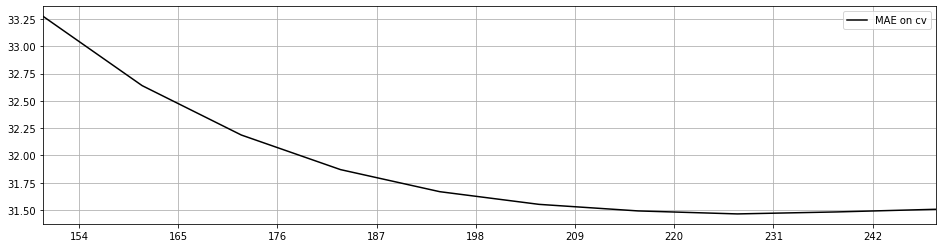

In [158]:
n_estimators = [i for i in range(150, 250, 11)]
target = 'n_estimators'
params = {'gamma': 0.05, 'n_estimators': 200, 'learning_rate': 0.01, 'colsample_bytree': 0.4}

xgbr = xgb.XGBRegressor()
param_search(xgbr, X_train, y_train, target, params, n_estimators)

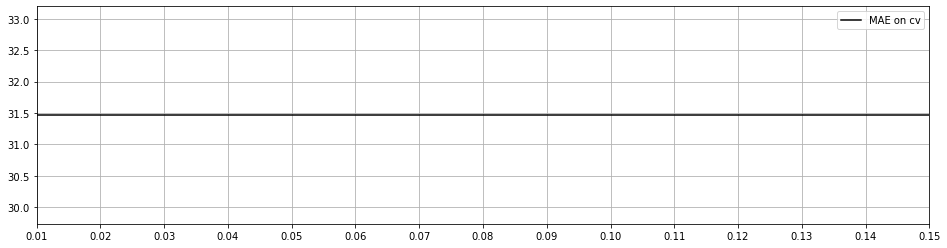

In [159]:
gamma = np.linspace(0.01, 0.15, 15)
target = 'gamma'
params = {'gamma': 0.05, 'n_estimators': 225, 'learning_rate': 0.01, 'colsample_bytree': 0.4}

xgbr = xgb.XGBRegressor()
param_search(xgbr, X_train, y_train, target, params, gamma)

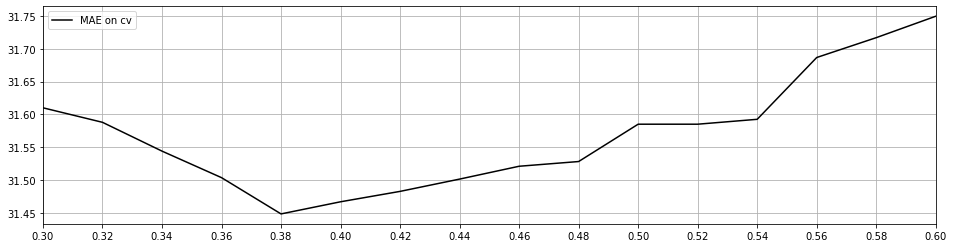

In [160]:
colsample_bytree = np.linspace(0.3, 0.6, 16)
target = 'colsample_bytree'
params = {'gamma': 0.05, 'n_estimators': 225, 'learning_rate': 0.01, 'colsample_bytree': 0.4}

xgbr = xgb.XGBRegressor()
param_search(xgbr, X_train, y_train, target, params, colsample_bytree)

Итак, лучшие параметры из анализируемых: 

In [34]:
params = {'gamma': 0.05, 'n_estimators': 225, 'learning_rate': 0.01, 'colsample_bytree': 0.38}
xgbr_best = xgb.XGBRegressor().set_params(**params)
validation(xgbr_best, X_train, y_train)

MAE: 31.448579321428447


<h3>XGBRF</h3>

In [93]:
xgbrf = xgb.XGBRFRegressor()
validation(xgbrf, X_train, y_train)

MAE: 35.98613177541287


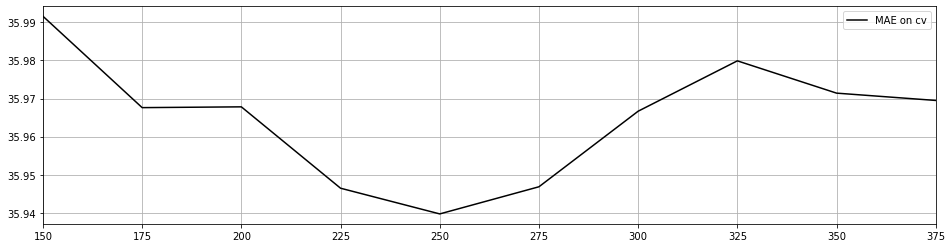

In [106]:
n_estimators = [i for i in range(150, 400, 25)]
target = 'n_estimators'
params = {'n_estimators': 200}

xgbrf = xgb.XGBRFRegressor()
param_search(xgbrf, X_train, y_train, target, params, n_estimators)

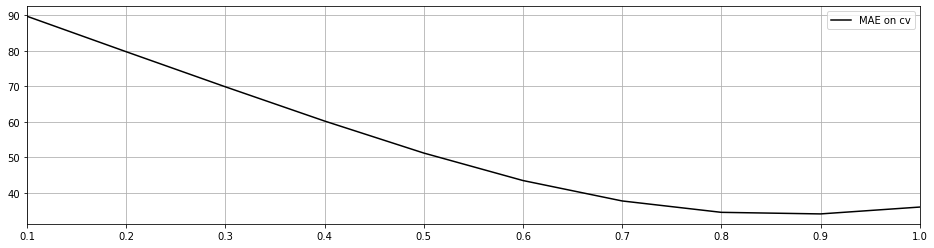

In [107]:
learning_rate = np.linspace(0.1, 1, 10)
target = 'learning_rate'
params = {'n_estimators': 250, 'learning_rate': 0.1}

xgbrf = xgb.XGBRFRegressor()
param_search(xgbrf, X_train, y_train, target, params, learning_rate)

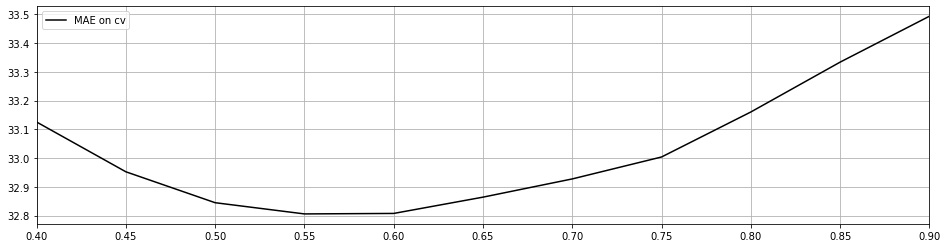

In [111]:
colsample_bytree = np.linspace(0.4, 0.9, 11)
target = 'colsample_bytree'
params = {'n_estimators': 250, 'colsample_bytree': 1, 'learning_rate': 0.85}

xgbrf = xgb.XGBRFRegressor()
param_search(xgbrf, X_train, y_train, target, params, colsample_bytree)

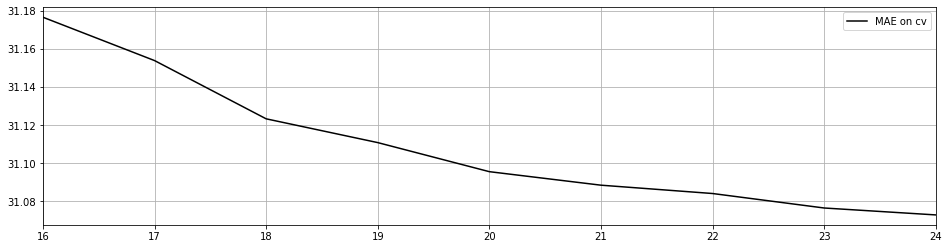

In [113]:
max_depth = [i for i in range(16, 25)]
target = 'max_depth'
params = {'n_estimators': 250, 'max_depth':10, 'colsample_bytree': 0.57, 'learning_rate': 0.85}

xgbrf = xgb.XGBRFRegressor()
param_search(xgbrf, X_train, y_train, target, params, max_depth)

После 20 скорость уменьшения замедляется. Оставим глубину 20, во избежание переобучения.

In [116]:
params = {'n_estimators': 250, 'max_depth': 20, 'colsample_bytree': 0.57, 'learning_rate': 0.85}

xgbrf_best = xgb.XGBRFRegressor().set_params(**params)
validation(xgbrf_best, X_train, y_train)

MAE: 31.095496927114063


<h3>Stacking</h3>

Попробуем использовать полученные модели для стэкинга.

In [119]:
level0 = list()
level0.append(('lgbm', lgbm_best))
level0.append(('xbgr', xgbr_best))
level0.append(('xbgrf', xgbrf_best))
level0.append(('r', r_best))
level0.append(('rf', rf_best))
level1 = Ridge()

In [120]:
stack_model = StackingRegressor(estimators = level0, final_estimator = level1, cv = 5)
validation(stack_model, X_train, y_train)

MAE: 32.23025900963695


In [122]:
alpha = [0.1, 0.5, 1, 10, 100]
for i in alpha:
    level1 = Ridge(alpha = i)
    stack_model = StackingRegressor(estimators = level0, final_estimator = level1, cv = 5)
    print('MAE on cross validation with alpha = {}: {}'.format(i, \
                                                               abs(cross_val_score(stack_model, X_test, y_test, cv = 4, scoring='neg_mean_absolute_error').mean())))

MAE on cross validation with alpha = 0.1: 32.912671207434244
MAE on cross validation with alpha = 0.5: 32.842758710472424
MAE on cross validation with alpha = 1: 32.878447249787975
MAE on cross validation with alpha = 10: 32.894336733590706
MAE on cross validation with alpha = 100: 32.89256378777522


К сожалению, так и не удалось подобрать модель первого уровня, чтобы комбинация моделей первого уровня приводила к улучшению качества прогнозов (в сравнении с лучшей моделью в одиночку).

<h3>Результат</h3>
<br>
Посмотрим детально на лучшию модели (XGBRegressor и XGBRFRegressor).

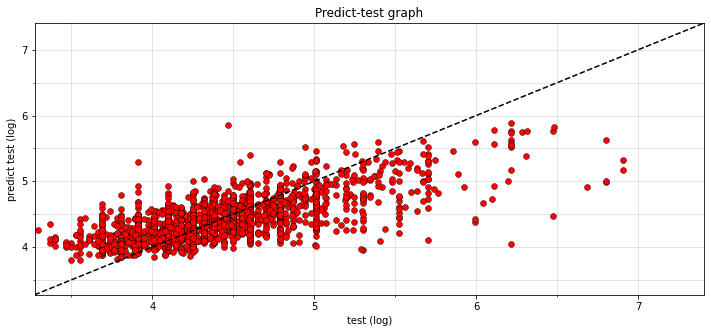

MAE: 29.55175190811895


In [38]:
xgbr_best.fit(X_train, y_train)
res_xgb = xgbr_best.predict(X_test)
error_compare(y_test, res_xgb)

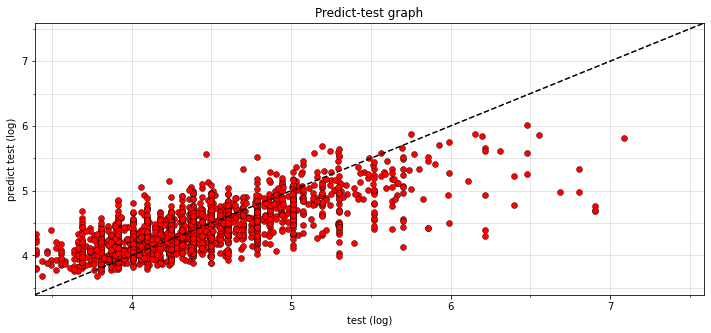

MAE: 29.956789709187476


In [123]:
params = {'n_estimators': 250, 'max_depth': 20, 'colsample_bytree': 0.57, 'learning_rate': 0.85}

xgbrf_best = xgb.XGBRFRegressor().set_params(**params)
xgbrf_best.fit(X_train, y_train)
xgbrf_best_res = xgbrf_best.predict(X_test)
error_compare(y_test, xgbrf_best_res)

Результат на тестовом множестве, которое модель раньше не видела, оказывается даже значительно лучше, чем усреднённые результаты при кроссвалидации. Это может быть обсуловлено «удачностью» тестового множества (например, отсутствием больших значений, дающих существенную ошибку). <br><br>
Проверим устойчивость результата, выполнив разбиение с разными зёрнами random_seed. <br>
Сделаем это для модели XGBRegressor (результат очень близок, но скорость её работы значительно лучше).

In [39]:
random = [i for i in range(1, 101)]
test = []
params = {'gamma': 0.05, 'n_estimators': 225, 'learning_rate': 0.01, 'colsample_bytree': 0.38}

for i in random:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = i)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    
    xgbr_best = xgb.XGBRegressor().set_params(**params)
    xgbr_best.fit(X_train, y_train)
    xgbr_best_res = xgbr_best.predict(X_test)
    test.append(mean_absolute_error(y_test, xgbr_best_res))
         
print('STD of MAE in 100 models: {}'.format(np.std(test)))
print('Min MAE: {}'.format(min(test)))
print('Max MAE: {}'.format(max(test)))

STD of MAE in 100 models: 1.3633035443110393
Min MAE: 28.456440293571234
Max MAE: 34.76174572126182


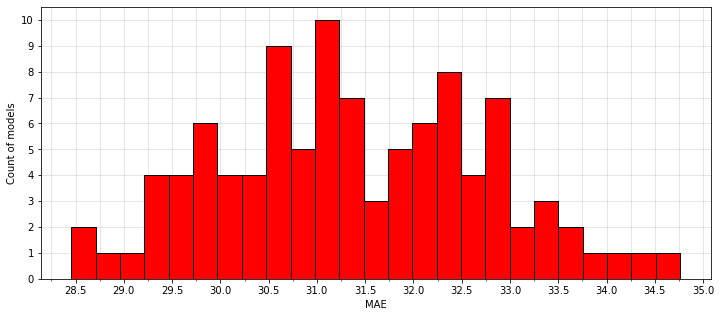

In [159]:
fig, ax = plt.subplots()
ax.hist(test, bins = 25, color = 'red', edgecolor = 'black')
fig.set_size_inches((12,5))
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.grid(alpha = 0.4, which = 'both')
ax.set_axisbelow(True)
ax.set_xlabel('MAE'), ax.set_ylabel('Count of models')
plt.show()

Как видим, в целом модель достаточно устойчива. В какой-то степени, тестовое множество действительно было достаточно «удачным», однако средняя абсолютная ошибка действительно группируется в районе 31-32, что и было получено при оценке ошибки на кроссвалидации.

Посмотрим на ошибки с несколько другого ракурса. Поймём, сколько объектов из тестового множества (вернёмся к множеству с random_seed = 42, с которым работали ранее) дали ошибку меньше заданного числа.

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

params = {'gamma': 0.05, 'n_estimators': 225, 'learning_rate': 0.01, 'colsample_bytree': 0.38}
xgbr_best = xgb.XGBRegressor().set_params(**params)
xgbr_best.fit(X_train, y_train)
xgbr_best_res = xgbr_best.predict(X_test)

In [161]:
res = pd.DataFrame({'test': y_test, 'predict': xgbr_best_res})
res.head()

,test,predict
8648,55,58.358509
131,100,76.216492
3514,58,95.220581
4408,100,71.229309
3100,90,100.590752


In [162]:
diff = [i for i in range(100)]
diff_border = pd.DataFrame(columns = ['error_limit', 'places'])
for i in diff:
    diff_border.loc[i] = i, len(res_xgb[abs(res.test - res.predict) < i])
diff_border.head()

,error_limit,places
0,0,0
1,1,81
2,2,144
3,3,209
4,4,277


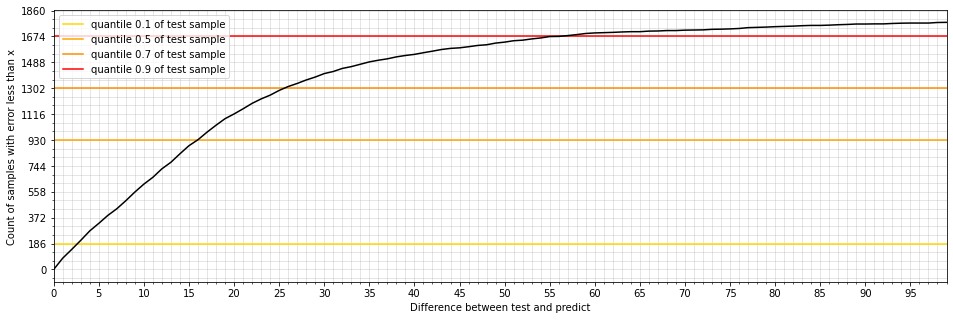

In [163]:
fig, ax = plt.subplots()
fig.set_size_inches((16,5))
ax.set_axisbelow(True)
ax.set_xlim(min(diff_border.error_limit), max(diff_border.error_limit))
ax.axhline(len(y_test)//10, color = 'gold', label = 'quantile 0.1 of test sample')
ax.axhline(len(y_test)//2, color = 'orange', label = 'quantile 0.5 of test sample')
ax.axhline(7*len(y_test)//10, color = 'darkorange', label = 'quantile 0.7 of test sample')
ax.axhline(9*len(y_test)//10, color = 'red', label = 'quantile 0.9 of test sample')
ax.plot(diff_border.error_limit, diff_border.places, color = 'black')
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(len(y_test)//10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(len(y_test)//30))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.grid(alpha = 0.4, which = 'both')
ax.set_xlabel('Difference between test and predict'), ax.set_ylabel('Count of samples with error less than x')
ax.legend()
plt.show() 

Мы видим, что:
- **10%** наблюдений имеют ошибку меньше, чем **3**
- **50%** наблюдений имеют ошибку меньше, чем **16**
- **70%** наблюдений имеют ошибку меньше, чем **26**
- **90%** наблюдений имеют ошибку меньше, чем **57**

Чтобы понять, насколько это хорошо или плохо, взглянем на статистику daily_price по всем объектам:

In [60]:
df.daily_price.describe()

count    9310.000000
mean      100.002041
std        90.715858
min        10.000000
25%        59.000000
50%        75.000000
75%       105.750000
max      1600.000000
Name: daily_price, dtype: float64

<h3>Итого</h3>

- При медианном значении стоимости аренды в сутки **75** и среднем **100** на 70% объектов модель ошибается меньше, чем на **26**.
- Модель неплохо себя показывает при стандартных значениях. Например, посмотрим среднюю ошибку на тестовом множестве для объектов, реальная стоимость аренды у которых $\leq$ 100.

In [69]:
res_lt100 = res[res.test <= 100]
np.mean(abs(res_lt100.test - res_lt100.predict))

16.082791791007434

Средняя ошибка для таких объектов $\approx$ 16. То есть, мы делаем прогноз с точностью $\pm$ 20%.

Отсюда очевидно обратное: недостаток модели. <br>
Модель плохо справляется с объектами, стоимость которых значительно выше средней стоимости по рынку. То есть, с выбросами. Даже при условии, что мы удалили объекты с дневной стоимостью 3000, мы получаем существенную ошибку на объектах высокой стоимости. 

In [73]:
res_gt1000 = res[res.test >= 1000]
np.mean(abs(res_gt1000.test - res_gt1000.predict))

869.3768183390299